# Longitudinal Data Assignment 1

## required Packages and Setup

In [89]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from sas7bdat import SAS7BDAT
import platform
import os
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from bioinfokit.analys import stat
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt
os.getcwd()
import rpy2
import saspy
import openpyxl
sas = saspy.SASsession(results='HTML')
%load_ext rpy2.ipython

Using SAS Config named: oda
SAS Connection established. Subprocess id is 2624

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [90]:
%%R

library(readxl)
library(haven)
library(broom.mixed)
library(ggplot2)
library(reshape2)
library(lme4)
library(mice)
library(VIM)
library(data.table)
library(tidyr)
library(dplyr)
library(matrixStats)
library(geepack)
library(wgeesel)
library(geeM)
library(gee)
#library(xlsx)

## Q1 Plots and necessary code for replication

### Setup help functions

In [91]:

%%R
#helpfunctions
#Biggest Point in a Vector which is not NA
groeste_not_na <- function(x){
  indic1 <- max(which(!is.na(x)))
  indic2 <- any(is.na(x[1:indic1]))
  if(indic2){
    return(100)
  }
  else{
    return(indic1)
  }
}



sampling_ids <- function(data,data_long,n, col){
  #generate n examples for wrong and false from the real observations
  #problem is that per chance id could be even for the grouped an integer, but
  #you have to test this
  Group_T <- data$id[data[col] == "1"]
  Group_F <- data$id[data[col] == "0"]
  numbers_T <- sample(Group_T,n)
  numbers_F <- sample(Group_F,n)
  return(data_long[data_long$id %in% c(numbers_T,numbers_F), ])
}


sampling_ids2 <- function(data,data_long,n, col,col_values){
  #generate n examples for wrong and false from the real observations
  #problem is that per chance id could be even for the grouped an integer, but
  #you have to test this
  params <- sapply(data[col],"%in%",col_values)
  Group_T <- data$id[params]
  numbers_T <- sample(x = Group_T,size = n)
  if (length(Group_T) == 1){
    numbers_T <- Group_T
  }
  return(data_long[data_long$id %in% c(numbers_T), ])
}

#example
#sampling_ids(data,data_long,10, "cardio")

#get_data_structured(data,c("male", "agegroup"))
get_data_structured <- function(data,group){
  structure <- cbind(data, Extra_info  = "NA")[0,]
  group_mean <- data%>% group_by(.dots = group) %>% summarise(across(where(
    is.numeric),function(x)mean(x, na.rm = T)))
  group_mean$Extra_info <- "group_mean"
  structure <- structure %>% add_row(group_mean)
  
  group_sd <- data%>% group_by(.dots = group) %>% summarise(across(where(
    is.numeric),function(x)sd(x, na.rm = T)))
  group_sd$Extra_info <- "group_sd"
  structure <- structure %>% add_row(group_sd)
  
  group_obs <- data%>% group_by(.dots = group) %>% summarise(across(where(
    is.numeric),function(x)length(x) - sum(is.na(x))))
  group_obs$Extra_info <- "group_obs"
  structure <- structure %>% add_row(group_obs)
  structure_long <- pivot_longer(structure, names_to = "years_after",
                                 cols = starts_with("HC"),names_prefix = "HC")
  structure_long$years_after <- as.numeric(structure_long$years_after)
  return(structure_long)
}

#takes a summary statistic of the form like all_data
get_confit <- function(data){
  obs <- nrow(data)/3
  data_changed <- data[1:obs,] %>%  mutate(Mean = data[1:obs,]$value, 
                                   Min = data[1:obs,]$value - 1.96 * data[(obs+1):(2*obs),]$value /sqrt(data[(2*obs+1):(3*obs),]$value),
                                   Max = data[1:obs,]$value + 1.96 * data[(obs+1):(2*obs),]$value /sqrt(data[(2*obs+1):(3*obs),]$value),
                                   Obs0 = rep(data[(2*obs+1):(3*obs),]$value[data[(2*obs+1):(3*obs),]$years_after == 0], each = 12),
                                   Obs10 = rep(data[(2*obs+1):(3*obs),]$value[data[(2*obs+1):(3*obs),]$years_after == 10], each = 12),
                                   
  )
  
  return(data_changed)
}
#get_confit(male_data_long)

#needs some kind of long_data as input with length 12
base_ggploting <- function(data, sqrt_scale = F){
  p <- data  %>% ggplot(aes(x = years_after, group = id,y = value))+ 
    labs(y = "Haematocrit", x = "years after")
  if(sqrt_scale){
    return(p + scale_x_continuous(trans='sqrt',breaks =c(0,0.5,1:10)))
  }
  else{
    return(p + scale_x_continuous(breaks =c(0,0.5,1:10)))
  }
}

#brings all the other steps together

#data is the dataframe
#group are all groups that should be taken into account put in a vector
Mean_Plot <- function(data, group){
  #calculates, mean, sd, and nr. of obs. (not na) for the defined group and puts it in a kind 
  #of long shape
  structure_long <- get_data_structured(data,substitute(group))
  #a bit reshaped, that now value for mean min and max have own column again
  Confint_read_to_plot <- get_confit(structure_long)
  return(Confint_read_to_plot)
}




### data changes

In [92]:

os.getcwd() 
os.chdir('C:\\Valentin\\Goettingen\\3_Semester\\Longitudinal\\Longitudinal_Data2021\\Assignment_1\\Analysis\\R_analysis')
#"C:/Valentin/Goettingen/3_Semester/Longitudinal/Longitudinal_Data2021/Assignment_1/Analysis/R_analysis"

In [93]:
%%R

require(haven)
require(tidyr)
require(ggplot2)
require(dplyr)


#read and initialize
data <- read_sas("..\\data\\renal.sas7bdat")
#es gibt eine Person ohne alter die lasse ich einfach weg
data <- data[-which(is.na(data$age)),]
data$male <- as.factor(data$male)
data$cardio <- as.factor(data$cardio)
data$reject <- as.factor(data$reject)
names(data)[names(data)== "HC06"] <- "HC0.5"
#extra variables
#persons per age intervall
data$agegroup <- cut(data$age, c(0,30,40,50,60,100),
                     labels = c("<=30","31-40","41-50","51-60","61+"))
#what is the last observed time point
not0s <- apply(data[,1:12],1,groeste_not_na)
data$not0s <- factor(not0s, labels = as.character(c(1:10,100)))
data$getsNA <- ifelse(is.na(data$HC10), 1,0)
cor(data$getsNA, as.numeric(data$age))


library(foreign)
library(xtable)


####Long Format####
data_long <- pivot_longer(data, names_to = "years_after",
                          cols = starts_with("HC"),names_prefix = "HC")
data_long$years_after <- as.numeric(data_long$years_after)

data_long$value2 <- c(NA,data_long$value[-length(data_long$value)])
#value 2 is the prevalue
data_long$change <- data_long$value - data_long$value2

data_long_changes <- data_long[data_long$years_after >= 1,]



#cor(data[,1:12])
#for comfort in sas
#achtung
#data_long$value <- log(data_long$value)
#data_long$years_after <- log(data_long$years_after+1)
#
data_long$years_after_2 <- data_long$years_after
data_long$years_after_square <- (data_long$years_after)^2
data_long$year0 <- ifelse(data_long$years_after == 0, 1,0)
data_long$year06 <- ifelse(data_long$years_after == 0.5, 1,0)




####set up summary####
summary_data <- cbind(data, Extra_info  = "NA")[0,]
####NA Analysis / nr of not Nas####
#number of NAs
n_NA <- data %>% summarise(across(where(
  is.numeric),function(x)sum(is.na(x))))



pattern <- rbind(c(1:10,100),tabulate(data_long_changes$not0s), tabulate(data_long_changes$not0s[data_long_changes$change > -5]))
data_pattern <- data.frame(not0s = as.factor(pattern[1,]), number = pattern[2,], number2 = pattern[3,])
data_changes_complete <- full_join(x = data_long_changes,y = data_pattern, by = "not0s")
data_changes_complete$correct_change <- data_changes_complete$change/data_changes_complete$number
data_changes_complete$correct_change2 <- data_changes_complete$change/data_changes_complete$number2

In [94]:
%%R
#decrease over time for complete and for those that are not complete
changes_not0s10 <- data_changes_complete$correct_change[data_changes_complete$not0s == 10]
print(sum(changes_not0s10))

changes_not0s_oth <- (data_changes_complete$correct_change[
  (data_changes_complete$not0s == data_changes_complete$years_after)
  & (data_changes_complete$not0s != 10 & data_changes_complete$not0s != 100)])
print(sum(changes_not0s_oth))
sd(changes_not0s10)
sd(changes_not0s_oth)
#what is the sd of the mean
print(sd(changes_not0s10) * sqrt(length(changes_not0s10)))
print((sd(changes_not0s_oth)* sqrt(length(changes_not0s_oth))))


#changes bigger than -5
#other periods
changes_not0s_oth <- (data_long_changes$change[
  (data_changes_complete$not0s == data_changes_complete$years_after)
  & (data_changes_complete$not0s != 10) 
  & (data_changes_complete$not0s != 100)])
changes_not0s_oth2 <- changes_not0s10 *length(changes_not0s10)
b <- changes_not0s_oth2
print(mean(b[b > -5]))
l1 <- length(b[b > -5])
hos <- sd(b[b > -5])/ sqrt(l1)
print(hos)
#period 10
print(mean(changes_not0s_oth[changes_not0s_oth>-5]) )
l2 <- length(changes_not0s_oth[changes_not0s_oth>-5])
ho <- sd(changes_not0s_oth[changes_not0s_oth>-5])/ sqrt(l2)
print(ho)
#variance of the difference
hose <- (var(changes_not0s_oth[changes_not0s_oth>-5])/l2 +  var(b[b > -5])/l1)*(l1+l2)
print(sqrt(hose/(l1+l2)))

[1] 0.01029498
[1] -0.4985275
[1] 0.06615596
[1] 0.141918
[1] 0.7538537
[1] 0.05516364
[1] 0.6011561
[1] 0.1289747
[1] 0.1402765


### More stuff needed for the Graphics

In [95]:
%%R
my_theme <-theme(axis.text = element_text(size = 15),
                 axis.title = element_text(size=20),
                 legend.text=element_text(size=20),
                 legend.title=element_text(size=20))

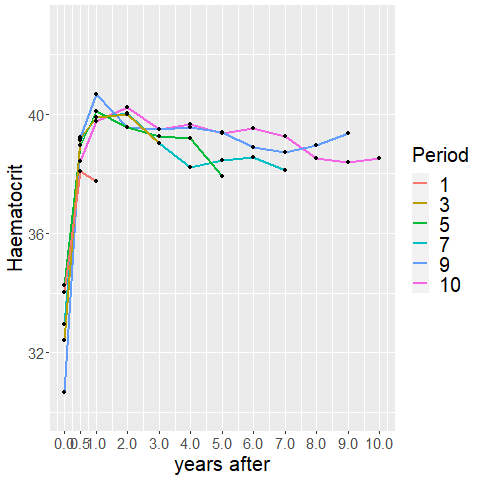

In [96]:
%%R
plotting <- get_data_structured(data,c("not0s"))
plotting <- get_confit(data = plotting)
plotting <- plotting[plotting$not0s %in% c("1","3","5","7","9","10"),]#23,
base_ggplot <- base_ggploting(plotting)+ ylim(c(30,43))
p1_1 <-base_ggplot + geom_line(aes(col = not0s),size=1) +
  geom_point() +labs(col="Period")+my_theme
p1_1

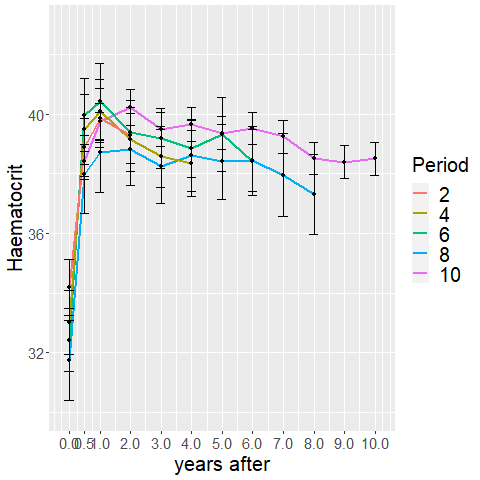

In [97]:
%%R
plotting <- get_data_structured(data,c("not0s"))
plotting <- get_confit(data = plotting)
plotting <- plotting[plotting$not0s %in% as.character(c(1:5)*2),]#23,
base_ggplot <- base_ggploting(plotting)+ ylim(c(30,43))
p1_2 <-base_ggplot + geom_line(aes(col = not0s),size=1) + 
  geom_point() +labs(col="Period")+my_theme+  geom_errorbar(aes(ymin= Min, ymax = Max), width=.3)
p1_2

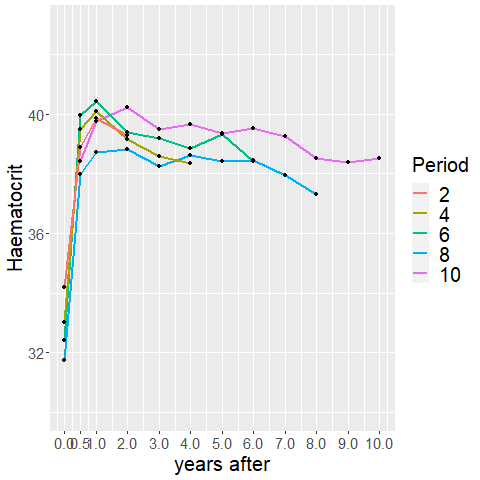

In [98]:
%%R
plotting <- get_data_structured(data,c("not0s"))
plotting <- get_confit(data = plotting)
plotting <- plotting[plotting$not0s %in% as.character(c(1:5)*2),]#23,
base_ggplot <- base_ggploting(plotting)+ ylim(c(30,43))
p1_2 <-base_ggplot + geom_line(aes(col = not0s),size=1) + 
  geom_point() +labs(col="Period")+my_theme
p1_2

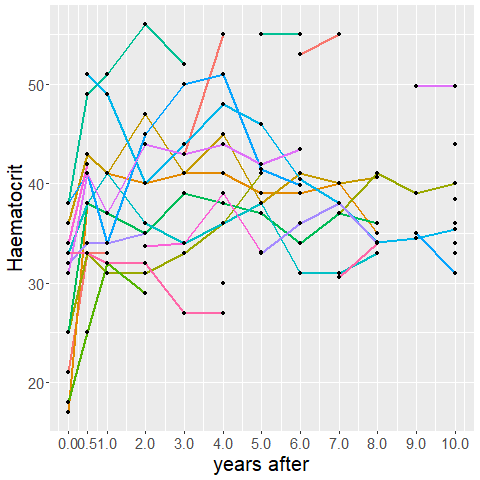

In [99]:
%%R
plotting <- sampling_ids2(data, data_long, 14, "not0s",col_values = 100)
base_ggplot <- base_ggploting(plotting, sqrt_scale = F)
p2_1 <- base_ggplot + geom_line(aes(col = as.factor(id)),size=1)+ 
  geom_point()+ scale_colour_discrete(guide=FALSE) + my_theme
p2_1

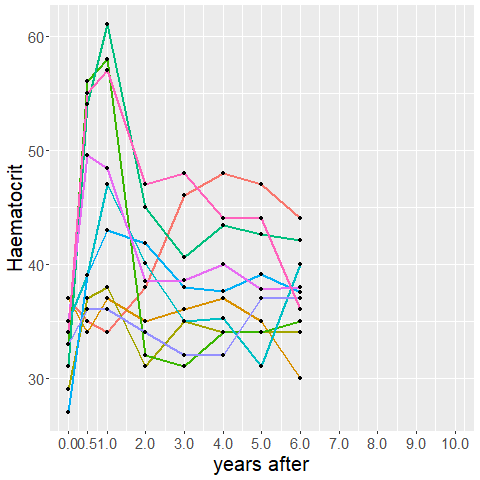

In [100]:
%%R
plotting <- sampling_ids2(data, data_long, 10, "not0s",c(6))
base_ggplot <- base_ggploting(plotting, sqrt_scale = F)
p3_1 <- base_ggplot + geom_line(aes(col = as.factor(id)),size=1)+
  geom_point()+ scale_colour_discrete(guide=FALSE) + my_theme
    p3_1

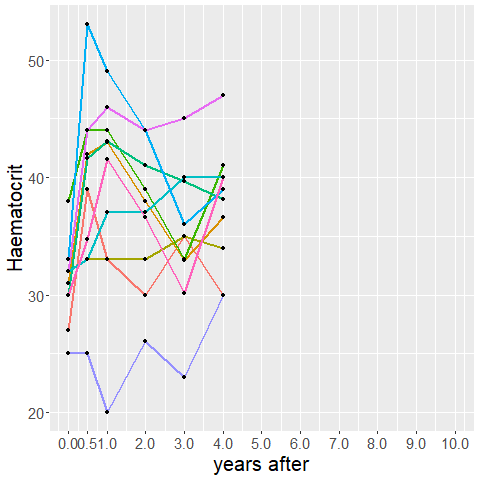

In [101]:
%%R
set.seed(23)
plotting <- sampling_ids2(data, data_long, 10, "not0s",c(4))
base_ggplot <- base_ggploting(plotting, sqrt_scale = F)
p3_2<- base_ggplot + geom_line(aes(col = as.factor(id)),size=1)+
  geom_point()+ scale_colour_discrete(guide=FALSE) + my_theme
p3_2

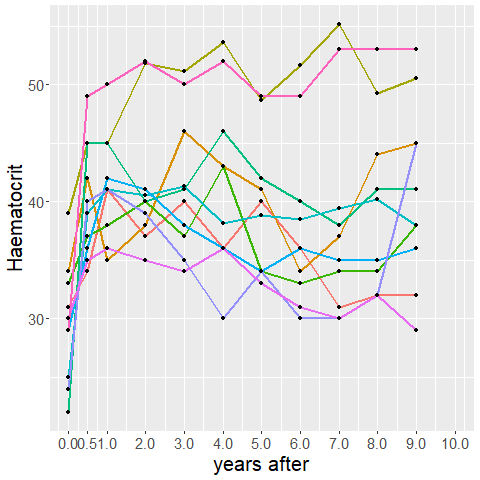

In [102]:
%%R
set.seed(23)
plotting <- sampling_ids2(data, data_long, 10, "not0s",c(9))
base_ggplot <- base_ggploting(plotting, sqrt_scale = F)
p3_3 <- base_ggplot + geom_line(aes(col = as.factor(id)),size=1)+
  geom_point()+ scale_colour_discrete(guide=FALSE) + my_theme
p3_3

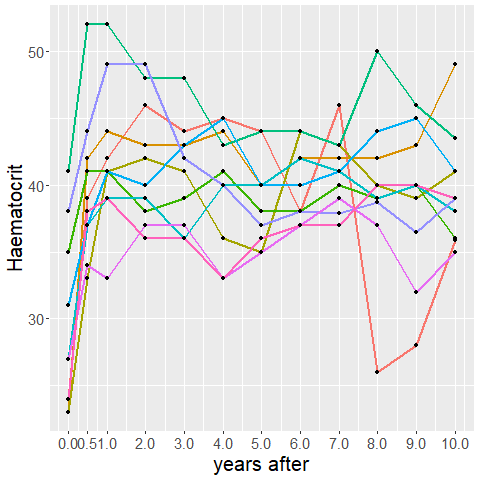

In [103]:
%%R
set.seed(23)
plotting <- sampling_ids2(data, data_long, 10, "not0s",c(10))
base_ggplot <- base_ggploting(plotting, sqrt_scale = F)
p3_4 <- base_ggplot + geom_line(aes(col = as.factor(id)),size=1)+
  geom_point()+ scale_colour_discrete(guide=FALSE) + my_theme
p3_4

In [104]:
%%R
data_long <- read_excel("C:\\Valentin\\Goettingen\\3_Semester\\Longitudinal\\Longitudinal_Data2021\\Assignment_1\\Analysis\\Assignment_3\\Code\\renal_long.xlsx")
data_short <- read_sas("C:\\Valentin\\Goettingen\\3_Semester\\Longitudinal\\Longitudinal_Data2021\\Assignment_1\\Analysis\\Assignment_3\\Code\\renal.sas7bdat")


data_long [data_long  == "NOVAL"] = NA
data_long[,"dln_hc"]=as.numeric(unlist(data_long[,"dln_hc"]))

dummy = rep(0,nrow(data_long))
for (i in 1:nrow(data_long)){
  if(data_long$time[i]==0.5){dummy[i]=1}
  else{dummy[i]=0}}
data_long$dummy0.5=dummy


### DIRECT LIKELIHOOD (LMM)

# Direct likelihood model
lmm <- lmer(dln_hc~dummy0.5+time+male+time:male +
            reject+reject:time +
              cardio+cardio:time +
              age+age:time+(1+time|id), 
            data=data_long, REML = TRUE)

summary(lmm)


R[write to console]: 
R[write to console]: -
R[write to console]: 
R[write to console]: \
                                                                              
R[write to console]: 
R[write to console]: New names:
* `` -> ...1

R[write to console]: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient



Linear mixed model fit by REML ['lmerMod']
Formula: dln_hc ~ dummy0.5 + time + male + time:male + reject + reject:time +  
    cardio + cardio:time + age + age:time + (1 + time | id)
   Data: data_long

REML criterion at convergence: -12066.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.0761 -0.4763  0.0412  0.5307  6.4481 

Random effects:
 Groups   Name        Variance  Std.Dev. Corr 
 id       (Intercept) 0.0445876 0.21116       
          time        0.0002688 0.01640  -0.22
 Residual             0.0073887 0.08596       
Number of obs: 8382, groups:  id, 1158

Fixed effects:
              Estimate Std. Error t value
(Intercept)  3.250e-01  2.673e-02  12.159
time        -8.448e-03  2.810e-03  -3.007
male         3.926e-02  1.320e-02   2.975
reject      -2.148e-02  1.429e-02  -1.503
cardio       2.126e-02  1.780e-02   1.194
age         -2.539e-03  5.216e-04  -4.867
time:male   -1.955e-03  1.394e-03  -1.403
time:reject  1.937e-03  1.474e-03   1.314
time:cardio -3.55


 Variables sorted by number of missings: 
 Variable       Count
 dln_hc10 0.700862069
  dln_hc9 0.646551724
  dln_hc8 0.580172414
  dln_hc7 0.513793103
  dln_hc6 0.438793103
  dln_hc5 0.361206897
  dln_hc4 0.271551724
  dln_hc3 0.177586207
  dln_hc2 0.075862069
  dln_hc1 0.001724138
 dln_hc06 0.000862069

 iter imp variable
  1   1  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  1   2  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  1   3  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  1   4  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  1   5  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  1   6  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9

  7   9  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  7   10  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  8   1  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  8   2  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  8   3  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  8   4  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  8   5  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  8   6  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  8   7  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  

  14   10  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  15   1  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  15   2  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  15   3  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  15   4  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  15   5  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  15   6  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  15   7  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  15   8  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  

  22   1  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  22   2  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  22   3  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  22   4  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  22   5  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  22   6  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  22   7  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  22   8  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  22   9  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  d

  29   2  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  29   3  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  29   4  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  29   5  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  29   6  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  29   7  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  29   8  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  29   9  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  29   10  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  

  36   3  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  36   4  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  36   5  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  36   6  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  36   7  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  36   8  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  36   9  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  36   10  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  37   1  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  

  43   4  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  43   5  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  43   6  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  43   7  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  43   8  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  43   9  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  43   10  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  44   1  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  44   2  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  

  50   5  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  50   6  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  50   7  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  50   8  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  50   9  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
  50   10  age  dln_hc06  dln_hc1  dln_hc2  dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9  dln_hc10
Class: mids
Number of multiple imputations:  10 
Imputation methods:
      id      age     male   cardio   reject dln_hc06  dln_hc1  dln_hc2 
      ""    "pmm"       ""       ""       ""    "pmm"    "pmm"    "pmm" 
 dln_hc3  dln_hc4  dln_hc5  dln_hc6  dln_hc7  dln_hc8  dln_hc9 dln_hc10 
   "pmm"    "pmm"    

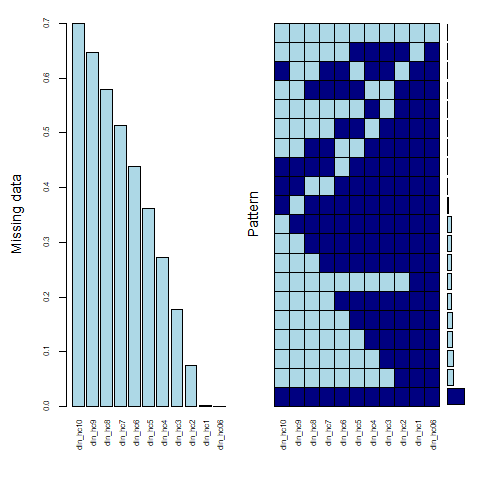

In [105]:
%%R
# MULTIPLE IMPUTATION 
data = data_short
# transform data
# log 
data["ln_hc0"] = log(data["HC0"])
data["ln_hc06"] = log(data["HC06"])
data["ln_hc1"] = log(data["HC1"])
data["ln_hc2"] = log(data["HC2"])
data["ln_hc3"] = log(data["HC3"])
data["ln_hc4"] = log(data["HC4"])
data["ln_hc5"] = log(data["HC5"])
data["ln_hc6"] = log(data["HC6"])
data["ln_hc7"] = log(data["HC7"])
data["ln_hc8"] = log(data["HC8"])
data["ln_hc9"] = log(data["HC9"])
data["ln_hc10"] = log(data["HC10"])

# diff
#data["ln_hc0"] = log(data["HC0"])
data["dln_hc06"] = log(data["HC06"])-log(data["HC0"])
data["dln_hc1"] = log(data["HC1"])-log(data["HC0"])
data["dln_hc2"] = log(data["HC2"])-log(data["HC0"])
data["dln_hc3"] = log(data["HC3"])-log(data["HC0"])
data["dln_hc4"] = log(data["HC4"])-log(data["HC0"])
data["dln_hc5"] = log(data["HC5"])-log(data["HC0"])
data["dln_hc6"] = log(data["HC6"])-log(data["HC0"])
data["dln_hc7"] = log(data["HC7"])-log(data["HC0"])
data["dln_hc8"] = log(data["HC8"])-log(data["HC0"])
data["dln_hc9"] = log(data["HC9"])-log(data["HC0"])
data["dln_hc10"] = log(data["HC10"])-log(data["HC0"])

data <- data[,13:40]
data <- data[,-(6:17)]

mice_plot <- aggr(data[,6:16], col=c('navyblue','lightblue'),
                  numbers=TRUE, sortVars=TRUE,
                  labels=names(data[,6:16]), cex.axis=.7,
                  gap=3, ylab=c("Missing data","Pattern"))


# impute and convert to long format
imp_data <- mice(data, m=10, maxit = 50, method = 'pmm', seed = 500)
summary(imp_data)
data_comp <- complete(imp_data, action="long", include=TRUE)



# MULTIPLE IMPUTATION LMM

# covert to long format
data_long_imp <- gather(data_comp,measurement, dln_hc, dln_hc06:dln_hc10, factor_key=TRUE)
data_long_imp <-data_long_imp[order(data_long_imp$.imp, data_long_imp$.id),]
data_long_imp["time"] <- rep(c(0.5,1,2,3,4,5,6,7,8,9,10),(nrow(data_long_imp)/11))
data_long_imp["dummy0.5"] <- rep(c(1,0,0,0,0,0,0,0,0,0,0),(nrow(data_long_imp)/11))
data_long_imp[".id"] <- seq(1,nrow(data_long_imp),1)
data_long_imp <- as.mids(data_long_imp, .imp = ".imp", .id = ".id")

# multiple imputation LMM
lmm_mi <- with(data = data_long_imp, exp <- lme4::lmer(dln_hc~dummy0.5+time+male+time:male +
                                          reject+reject:time+
                                          cardio+cardio:time +
                                          age+age:time+ (1+time|id),
                                          na.action=na.omit, REML = TRUE)) 

## Pooled Estimates
combine <- pool(lmm_mi)
summary(combine)

In [106]:
%%R
data_long <- read_excel("C:\\Valentin\\Goettingen\\3_Semester\\Longitudinal\\Longitudinal_Data2021\\Assignment_1\\Analysis\\Assignment_3\\Code\\renal_long.xlsx")
data_short <- read_sas("C:\\Valentin\\Goettingen\\3_Semester\\Longitudinal\\Longitudinal_Data2021\\Assignment_1\\Analysis\\Assignment_3\\Code\\renal.sas7bdat")
data_long$time <- rep(c(0.5,1,2,3,4,5,6,7,8,9,10),(nrow(data_long)/11))


data_base=data_short[,c(1,13)]
data_base$HC0=log(data_short$HC0)
data_long$dln_hc = as.numeric(data_long$dln_hc)

data_long=merge(data_long, data_base)

dropout = rep(0,nrow(data_long))
for (i in 1:nrow(data_long)){
  if(is.na(data_long$dln_hc[i])){dropout[i]=0}
  else{dropout[i]=1}}
data_long$dropout=dropout
data_long$Observation=seq(1,nrow(data_long),1)


# add lag variables
dln_hc_1 = rep(0,nrow(data_long))
for (i in 1:nrow(data_long)){
  if(data_long$time[i]==0.5){dln_hc_1[i]=NA}
  if(data_long$time[i]!=0.5){dln_hc_1[i]=data_long$dln_hc[i-1]}}

nrow(data_long)

dln_hc_2 = rep(0,nrow(data_long))
for (i in 1:nrow(data_long)){
  if(data_long$time[i]<=1){dln_hc_2[i]=NA}
  if(data_long$time[i]>1){dln_hc_2[i]=data_long$dln_hc[i-2]}}

dln_hc_3 = rep(0,nrow(data_long))
for (i in 1:nrow(data_long)){
  if(data_long$time[i]<=2){dln_hc_3[i]=NA}
  if(data_long$time[i]>2){dln_hc_3[i]=data_long$dln_hc[i-3]}}

data_long$dln_hc_1 = dln_hc_1
data_long$dln_hc_2 = dln_hc_2
data_long$dln_hc_3 = dln_hc_3


R[write to console]: 
R[write to console]: -
R[write to console]: 
R[write to console]: \
                                                                              
R[write to console]: 
R[write to console]: New names:
* `` -> ...1



In [107]:
%%R
##### SELECTION MODEL

# lmm part of selection model
sm_lmm <- lmer(dln_hc~time+HC0+HC0:time+male+time:male +
              reject+reject:time +
              cardio+cardio:time +
              age+age:time+(1+time|id), 
            data=data_long, REML = TRUE)

summary(sm_lmm)

# glm poart of selection model (MAR)
sm_dropout_mar <- glm(dropout ~ dln_hc_1 + time + time*HC0 + dln_hc_2 + 
                        reject + male + cardio + age +
                        time:reject + time:male + time:cardio + time:age,
                      family=binomial(link='logit'),data=data_long)
summary(sm_dropout_mar)

# glm part of selection model (MNAR)
sm_dropout_mnar <- glm(dropout ~ dln_hc + dln_hc_1 + time + time*HC0 + dln_hc_2 + 
                        reject + male + cardio + age +
                        time:reject + time:male + time:cardio + time:age,
                      family=binomial(link='logit'), data=data_long, maxit = 100000000000)
summary(sm_dropout_mnar)


Call:
glm(formula = dropout ~ dln_hc + dln_hc_1 + time + time * HC0 + 
    dln_hc_2 + reject + male + cardio + age + time:reject + time:male + 
    time:cardio + time:age, family = binomial(link = "logit"), 
    data = data_long, maxit = 1e+11)

Deviance Residuals: 
      Min         1Q     Median         3Q        Max  
2.107e-08  2.107e-08  2.107e-08  2.107e-08  2.107e-08  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)
(Intercept)  3.157e+01  4.028e+07       0        1
dln_hc      -6.482e-08  8.846e+06       0        1
dln_hc_1    -5.701e-09  9.964e+06       0        1
time         9.362e-08  5.623e+06       0        1
HC0          2.785e-08  1.172e+07       0        1
dln_hc_2    -6.830e-08  8.978e+06       0        1
reject      -2.532e-07  4.281e+06       0        1
male        -2.692e-08  4.056e+06       0        1
cardio       2.090e-08  5.525e+06       0        1
age          7.549e-09  1.651e+05       0        1
time:HC0    -8.854e-09  1.692e+06       0   

In [108]:
%%R
library(glmnet)
## lasso regression
x.cont=data_long[c(3,4,5,6,9,8,17,20,21,22)]
x.cont$HC0=x.cont$HC0*x.cont$time
x.cont$male_time=x.cont$male*x.cont$time
x.cont$cardio_time=x.cont$cardio*x.cont$time
x.cont$reject_time=x.cont$reject*x.cont$time
x.cont$age_time=x.cont$age*x.cont$time
x_var = data.matrix(x.cont)
y_var <- data_long[, "dropout"]

lambda_seq <- 10^seq(2, -2, by = -.1)
ridge_cv <- cv.glmnet(x=x_var, y=y_var, alpha = 0, lambda = lambda_seq)
best_lambda <- ridge_cv$lambda.min
best_lambda

sm_dropout_mnar_ridge <- glmnet(x=x_var, y=y_var, alpha = 0, lambda  = best_lambda)
summary(sm_dropout_mnar_ridge)
coef(sm_dropout_mnar_ridge)

15 x 1 sparse Matrix of class "dgCMatrix"
                      s0
(Intercept)  1.035740028
age          .          
male         0.002749623
cardio      -0.005311490
reject       0.029638776
time        -0.073555561
dln_hc       .          
HC0          .          
dln_hc_1     .          
dln_hc_2     .          
dln_hc_3     .          
male_time   -0.009064032
cardio_time -0.006612245
reject_time  0.009365522
age_time     .          


In [109]:
import pandas as pd
tabelle1 = pd.read_excel("C:/Valentin/Goettingen/3_Semester/Longitudinal/Longitudinal_Data2021/Assignment_1/data/data_long_dropout.xlsx")
tabelle2 = pd.read_excel("C:/Valentin/Goettingen/3_Semester/Longitudinal/Longitudinal_Data2021/Assignment_1/data/data_short_mi.xlsx")

In [110]:

tabelle1_sas = sas.df2sd(tabelle1, table = 'renal_long_dropout')
tabelle2_sas = sas.df2sd(tabelle2, table = 'data_short_mi')

In [111]:
%%SAS sas

*libname l*da "/home/u49851623/LDA2021/input";
*libname lda_res "/home/u49851623/LDA2021/output";
*libname macro "/home/u49851623/LDA2021/Assignment3";

* Import data in wide format;
*PROC IMPORT OUT=lda.renal_long_dropout*
*		DATAFILE="/home/u49851623/LDA2021/input/data_long_dropout.xlsx"
*		DBMS= XLSX REPLACE;
*run;
*
*PROC IMPORT OUT=lda.data_short_mi
*		DATAFILE="/home/u49851623/LDA2021/input/data_short_mi.xlsx"
*		DBMS= XLSX REPLACE;
*run;


* Sort data by id;
proc sort data=renal_long_dropout out=renal_long_dropout_sort;
   by id;
run;

* Add copy of time column;
data renal_long_dropout_sort;
 set renal_long_dropout_sort;
 timeclss = time ;
run;

*%include "/home/u49851623/LDA2021/Assignment3/weight.sas";

In [112]:
%%SAS sas

* Sort data by id;
proc sort data=renal_long_dropout out=renal_long_dropout_sort;
   by id;
run;

* Add copy of time column;
data renal_long_dropout_sort;
 set renal_long_dropout_sort;
 timeclss = time ;
run;

*%include "/home/u49851623/LDA2021/Assignment3/weight.sas";

In [113]:
%%SAS sas
* logistic regression for weight model;
proc genmod data=renal_long_dropout_sort;
class reject cardio male;
model dropout = reject cardio male age time reject*time cardio*time male*time age*time/pred dist=b;
ods output obstats=pred;
run;


In [114]:

#prediction = sas.sd2df_DISK("pred")
#prediction
#prediction = prediction.rename(columns={'Pred': 'pred'})
#renal_wgee = prediction.merge(tabelle1, on='Observation', how='outer')
#renal_wgee['timeclss'] = renal_wgee['time']
#data_wgee = renal_wgee[["id","time","pred","dropout"]]
#data_wgee.drop(labels='Locations', axis=1)

In [115]:
%%SAS sas
%macro dropwgt(data=,id=,time=,pred=,dropout=,out=);
%if %bquote(&data)= %then %let data=&syslast;
proc freq data=&data noprint;
tables &id /out=freqid;
tables &time / out=freqtime;
run;
proc iml;
reset noprint;
use freqid;
read all var {&id};
nsub = nrow(&id);
use freqtime;
read all var {&time};
ntime = nrow(&time);
time = &time;
use &data;
read all var {&id &time &pred &dropout};
n = nrow(&pred);
wi = j(n,1,1);
ind = 1;
do while (ind <= nsub);
wihlp = 1;
stay = 1;
/* first measurement */
if (&dropout[(ind-1)*ntime+2]=1)
then do;
wihlp = pred[(ind-1)*ntime+2];
stay = 0;
end;
else if (&dropout[(ind-1)*ntime+2]=0)
then wihlp = 1-pred[(ind-1)*ntime+2];
/* second to penultimate measurement */
j=2;
do while ((j <= ntime-1) & stay);
if (&dropout[(ind-1)*ntime+j+1]=1)
then do;
wihlp = wihlp*pred[(ind-1)*ntime+j+1];
stay = 0;
end;
else if (&dropout[(ind-1)*ntime+j+1]=0)
then wihlp = wihlp*(1-pred[(ind-1)*ntime+j+1]);
j = j+1;
end;
j = 1;
do while (j <= ntime);
wi[(ind-1)*ntime+j]=wihlp;
j = j+1;
end;
ind = ind+1;
end;
create help var {&id &time &pred &dropout wi};
append;
quit;
data &out;
merge &data help;
data &out;
set &out;
wi=1/wi;
run;
%mend;

In [116]:
%%SAS sas
data pred;
set pred;
keep observation pred;
run;

data renal_wgee;
merge pred renal_long_dropout_sort;
by observation;
run;
%dropwgt(data=renal_wgee,id=id,time=time,pred=pred,dropout=dropout,out=data_wgee);


In [117]:

#prediction = sas.sd2df_DISK("pred")
#prediction
#prediction = prediction.rename(columns={'Pred': 'pred'})
#renal_wgee = prediction.merge(tabelle1, on='Observation', how='outer')
#renal_wgee['timeclss'] = renal_wgee['time']
#data_wgee = renal_wgee[["id","time","pred","dropout"]]
#data_wgee.drop(labels='Locations', axis=1)
#renal_wgee = sas.sd2df_DISK("renal_wgee")
#data_wgee = renal_wgee[[]]

In [118]:
sas.sd2df_DISK("data_wgee")

Observation      Pred  Unnamed: 0      id   age  male  cardio  reject  \
0              1.0  0.029805         1.0     1.0  25.0   1.0     0.0     1.0   
1              2.0  0.042982         2.0     1.0  25.0   1.0     0.0     1.0   
2              3.0  0.061615         3.0     1.0  25.0   1.0     0.0     1.0   
3              4.0  0.087585         4.0     1.0  25.0   1.0     0.0     1.0   
4              5.0  0.123066         5.0     1.0  25.0   1.0     0.0     1.0   
...            ...       ...         ...     ...   ...   ...     ...     ...   
12601      12602.0  0.576323     12602.0  1160.0  68.0   1.0     1.0     0.0   
12602      12603.0  0.691345     12603.0  1160.0  68.0   1.0     1.0     0.0   
12603      12604.0  0.786697     12604.0  1160.0  68.0   1.0     1.0     0.0   
12604      12605.0  0.858616     12605.0  1160.0  68.0   1.0     1.0     0.0   
12605      12606.0  0.909089     12606.0  1160.0  68.0   1.0     1.0     0.0   

      measurement    dln_hc  time  hc_m  hc_m_1  hc_m_2  hc_m_3  dropout  \
0        dln_hc06  0.455476   0.0   0.0     0.0     NaN     NaN      1.0   
1         dln_hc1  0.479573   1.0   0.0     0.0     NaN     NaN      1.0   
2         dln_hc2  0.526093   2.0   0.0     0.0     0.0     NaN      1.0   
3         dln_hc3  0.526093   3.0   0.0     0.0     0.0     0.0      1.0   
4         dln_hc4  0.548566   4.0   0.0     0.0     0.0     0.0      1.0   
...           ...       ...   ...   ...     ...     ...     ...      ...   
12601     dln_hc6       NaN   6.0   NaN     0.0     NaN     NaN      0.0   
12602     dln_hc7       NaN   7.0   NaN     0.0     NaN     NaN      0.0   
12603     dln_hc8       NaN   8.0   NaN     0.0     NaN     NaN      0.0   
12604     dln_hc9       NaN   9.0   NaN     0.0     NaN     NaN      0.0   
12605    dln_hc10       NaN  10.0   NaN     0.0     NaN     NaN      0.0   

       timeclss         WI  
0           0.0  23.265511  
1           1.0  23.265511  
2           2.0  23.265511  
3           3.0  23.265511  
4           4.0  23.265511  
...         ...        ...  
12601       6.0   9.898457  
12602       7.0   9.898457  
12603       8.0   9.898457  
12604       9.0   9.898457  
12605      10.0   9.898457  

[12606 rows x 18 columns]

In [119]:
%%SAS sas
* WGEE using proc gee observation level weights;
proc genmod data=data_wgee descending;
scwgt wi;
class timeclss id reject cardio male;
model hc_m = time reject cardio age male 
time*reject time*cardio time*male time*age/ dist=b;
repeated subject=id/ type=un corrw within=timeclss modelse;
run;

In [120]:
sas.sd2df_DISK("data_wgee")

#sas.sd2df_DISK("renal_wgee")

Observation      Pred  Unnamed: 0      id   age  male  cardio  reject  \
0              1.0  0.029805         1.0     1.0  25.0   1.0     0.0     1.0   
1              2.0  0.042982         2.0     1.0  25.0   1.0     0.0     1.0   
2              3.0  0.061615         3.0     1.0  25.0   1.0     0.0     1.0   
3              4.0  0.087585         4.0     1.0  25.0   1.0     0.0     1.0   
4              5.0  0.123066         5.0     1.0  25.0   1.0     0.0     1.0   
...            ...       ...         ...     ...   ...   ...     ...     ...   
12601      12602.0  0.576323     12602.0  1160.0  68.0   1.0     1.0     0.0   
12602      12603.0  0.691345     12603.0  1160.0  68.0   1.0     1.0     0.0   
12603      12604.0  0.786697     12604.0  1160.0  68.0   1.0     1.0     0.0   
12604      12605.0  0.858616     12605.0  1160.0  68.0   1.0     1.0     0.0   
12605      12606.0  0.909089     12606.0  1160.0  68.0   1.0     1.0     0.0   

      measurement    dln_hc  time  hc_m  hc_m_1  hc_m_2  hc_m_3  dropout  \
0        dln_hc06  0.455476   0.0   0.0     0.0     NaN     NaN      1.0   
1         dln_hc1  0.479573   1.0   0.0     0.0     NaN     NaN      1.0   
2         dln_hc2  0.526093   2.0   0.0     0.0     0.0     NaN      1.0   
3         dln_hc3  0.526093   3.0   0.0     0.0     0.0     0.0      1.0   
4         dln_hc4  0.548566   4.0   0.0     0.0     0.0     0.0      1.0   
...           ...       ...   ...   ...     ...     ...     ...      ...   
12601     dln_hc6       NaN   6.0   NaN     0.0     NaN     NaN      0.0   
12602     dln_hc7       NaN   7.0   NaN     0.0     NaN     NaN      0.0   
12603     dln_hc8       NaN   8.0   NaN     0.0     NaN     NaN      0.0   
12604     dln_hc9       NaN   9.0   NaN     0.0     NaN     NaN      0.0   
12605    dln_hc10       NaN  10.0   NaN     0.0     NaN     NaN      0.0   

       timeclss         WI  
0           0.0  23.265511  
1           1.0  23.265511  
2           2.0  23.265511  
3           3.0  23.265511  
4           4.0  23.265511  
...         ...        ...  
12601       6.0   9.898457  
12602       7.0   9.898457  
12603       8.0   9.898457  
12604       9.0   9.898457  
12605      10.0   9.898457  

[12606 rows x 18 columns]

In [121]:
%%SAS sas
* imputation;

proc mi data=data_short_mi seed=26 simple out=data_mi_shift1 nimpute=10 
		round=0.0001;
	var dln_hc06 dln_hc1 dln_hc2 dln_hc3 dln_hc4 dln_hc5 
	dln_hc6 dln_hc7 dln_hc8 dln_hc9 dln_hc10;
	fcs reg;
run;



In [122]:
%%SAS sas
* add binary indicator;

proc sort data=data_mi_shift1;
	by id _imputation_ reject male cardio age;
run;

*transpose data;

proc transpose data=data_mi_shift1 out=data_mi_shift1_long;
	by id _imputation_ reject male cardio age;
run;

* add time rename;

data data_mi_shift1_long2;
	set data_mi_shift1_long;
	rename COL1=dln_hc;
	time=0.5;

	if _NAME_="dln_hc1" then
		time=1;

	if _NAME_="dln_hc2" then
		time=2;

	if _NAME_="dln_hc3" then
		time=3;

	if _NAME_="dln_hc4" then
		time=4;

	if _NAME_="dln_hc5" then
		time=5;

	if _NAME_="dln_hc6" then
		time=6;

	if _NAME_="dln_hc7" then
		time=7;

	if _NAME_="dln_hc8" then
		time=8;

	if _NAME_="dln_hc9" then
		time=9;

	if _NAME_="dln_hc10" then
		time=10;
run;
* add binary indicator;

data data_mi_shift1_long2;
	set data_mi_shift1_long2;
	hc_m=0;

	if dln_hc<=0.09812394 then
		hc_m=1;
	timeclss=time;
run;

* sort for analysis;

proc sort data=data_mi_shift1_long2;
	by _imputation_ id time;
run;



In [123]:
#sas.sd2df_DISK("data_mi_shift1_long2")
import pandas as pd
df = sas.sd2df_DISK("data_mi_shift1_long2")
df.drop(df[df._NAME_ == "Unnamed: 0"].index, inplace=True)

#prediction = prediction.iloc[["_NAME_"!="Unamed: 0"]]
#irgendwie noch eine komische zeile dabei die raus muss
data_mi_shift1_long2_sas = sas.df2sd(df, table = 'data_mi_shift1_long2')


C:\Valentin\Goettingen\3_Semester\Longitudinal\Longitudinal_Data2021\Assignment_1\Analysis\sas\lib\site-packages\saspy\sasioiom.py:1531: UserWarning: Note that Indexes are not transferred over as columns. Only actual coulmns are transferred
  warnings.warn("Note that Indexes are not transferred over as columns. Only actual coulmns are transferred")


In [124]:
%%SAS sas

* analysis task: gee;
proc gee data=data_mi_shift1_long2 descending;
	class id reject male cardio timeclss;
	by _imputation_;
	model hc_m=time male cardio reject age time*male time*reject time*cardio 
		time*age/dist=binomial;
	repeated subject=id/ withinsubject=timeclss type=unstr modelse;
	ods output GEEEmpPEst=gmparms parminfo=gmpinfo CovB=gmcovb;
run;

data gmparms;
   set gmparms;
   if Z=. then delete;
run;

* inference task;

proc mianalyze parms=gmparms wcov bcov tcov;
	modeleffects time male cardio reject age time*male time*reject time*cardio 
		time*age;
run;

In [125]:
%%SAS sas
* imputation with ncmv/ccmv/acmv;

proc sort data=data_short_mi;
	by reject cardio male age;
run;

proc mi data=data_short_mi seed=26 simple out=data_mi_shift1 
    nimpute=10 round=0.0001;
    var age dln_hc06 dln_hc1 dln_hc2 dln_hc3 dln_hc4 
	dln_hc5 dln_hc6 dln_hc7 dln_hc8 dln_hc9 dln_hc10;
	mcmc impute=monotone;
	*by reject;
run;

proc mi data=data_mi_shift1 seed=26 simple out=data_mi_shift2 
    nimpute=1 round=0.0001;
	var age dln_hc06 dln_hc1 dln_hc2 dln_hc3 dln_hc4 
	dln_hc5 dln_hc6 dln_hc7 dln_hc8 dln_hc9 dln_hc10;
	monotone reg;
	mnar model (dln_hc06 dln_hc1 dln_hc2 dln_hc3 dln_hc4 dln_hc5 
	dln_hc6 dln_hc7 dln_hc8 dln_hc9 dln_hc10/ modelobs=ncmv);
	*by reject cardio male age;
run;



In [126]:
%%SAS sas
* add binary indicator;

proc sort data=data_mi_shift2;
	by id _imputation_ reject male cardio age;
run;

*transpose data;

proc transpose data=data_mi_shift2 out=data_mi_shift1_long;
	by id _imputation_ reject male cardio age;
run;

* add time rename;

data data_mi_shift1_long2;
	set data_mi_shift1_long;
	rename COL1=dln_hc;
	time=0.5;

	if _NAME_="dln_hc1" then
		time=1;

	if _NAME_="dln_hc2" then
		time=2;

	if _NAME_="dln_hc3" then
		time=3;

	if _NAME_="dln_hc4" then
		time=4;

	if _NAME_="dln_hc5" then
		time=5;

	if _NAME_="dln_hc6" then
		time=6;

	if _NAME_="dln_hc7" then
		time=7;

	if _NAME_="dln_hc8" then
		time=8;

	if _NAME_="dln_hc9" then
		time=9;

	if _NAME_="dln_hc10" then
		time=10;
run;

* add binary indicator;

data data_mi_shift1_long2;
	set data_mi_shift1_long2;
	hc_m=0;

	if dln_hc<=0.09812394 then
		hc_m=1;
	timeclss=time;
run;

* add binary indicator;

data data_mi_shift1_long2;
	set data_mi_shift1_long2;
	dummy_05=0;

	if time=0.5 then
		dummy_05=1;
run;

* sort for analysis;

proc sort data=data_mi_shift1_long2;
	by _imputation_ id time;
run;


In [127]:
#sas.sd2df_DISK("data_mi_shift1_long2")

df = sas.sd2df_DISK("data_mi_shift1_long2")
df.drop(df[df._NAME_ == "Unnamed: 0"].index, inplace=True)

#prediction = prediction.iloc[["_NAME_"!="Unamed: 0"]]
#irgendwie noch eine komische zeile dabei die raus muss
data_mi_shift1_long2_sas = sas.df2sd(df, table = 'data_mi_shift1_long2')

In [128]:
%%SAS sas
* analysis tast: gee;

proc genmod data=data_mi_shift1_long2 descending;
	by _imputation_;
	class id timeclss male cardio reject/param=ref;
	model hc_m=male age cardio reject time male*time age*time 
		cardio*time reject*time/dist=binomial covb;
	repeated subject=id/ withinsubject=timeclss type=ar covb corrw modelse;
	ods output GEEEmpPEst=gmparms parminfo=gmpinfo CovB=gmcovb;
run;

* the inference task gee;

proc mianalyze parms=gmparms wcov bcov tcov;
	modeleffects time male cardio reject age time*male time*reject time*cardio 
		time*age;
run;

In [133]:
%%SAS sas
* analysis task lmm;
proc mixed data=data_mi_shift1_long2 method=ml  INFLUENCE;
	by _imputation_;
	class id male cardio reject timeclss;
	model dln_hc=male age cardio reject time dummy_05 male*time age*time cardio*time 
		reject*time/ s residual ;
	random intercept time/ type=un subject=id gcorr;
	repeated timeclss/ local subject=id rcorr;
	ods output SolutionF=mixedcoeff;
run;

data mixedcoeff;
   set mixedcoeff;
   if DF=. then delete;
run;

* inference task: lmm;
proc mianalyze parms=mixedcoeff;
	modeleffects time male cardio reject age dummy_05 time*male time*reject time*cardio 
		time*age;
run;

In [130]:
%%SAS sas
* imputation with shift;

proc mi data=data_short_mi seed=26 simple out=data_mi_shift1 nimpute=10 
		round=0.0001;
	class male;
	var dln_hc06 dln_hc1 dln_hc2 dln_hc3 dln_hc4 dln_hc5 
	dln_hc6 dln_hc7 dln_hc8 dln_hc9 dln_hc10;
	fcs reg;
	mnar adjust(dln_hc06/ SIGMA=0.5 adjustobs=(male="1"));
	mnar adjust(dln_hc1/ SIGMA=0.5 adjustobs=(male="1"));
	mnar adjust(dln_hc2/ SIGMA=0.5 adjustobs=(male="1"));
	mnar adjust(dln_hc3/ SIGMA=0.5 adjustobs=(male="1"));
	mnar adjust(dln_hc4/ SIGMA=0.5 adjustobs=(male="1"));
	mnar adjust(dln_hc5/ SIGMA=0.5 adjustobs=(male="1"));
	mnar adjust(dln_hc6/ SIGMA=0.5 adjustobs=(male="1"));
	mnar adjust(dln_hc7/ SIGMA=0.5 adjustobs=(male="1"));
	mnar adjust(dln_hc8/ SIGMA=0.5 adjustobs=(male="1"));
	mnar adjust(dln_hc9/ SIGMA=0.5 adjustobs=(male="1"));
	mnar adjust(dln_hc10/ SIGMA=0.5 adjustobs=(male="1"));
	*by reject;
run;

* add binary indicator;

proc sort data=data_mi_shift1;
	by id _imputation_ reject male cardio age;
run;

*transpose data;

proc transpose data=data_mi_shift1 out=data_mi_shift1_long;
	by id _imputation_ reject male cardio age;
run;

* add time rename;

data data_mi_shift1_long2;
	set data_mi_shift1_long;
	rename COL1=dln_hc;
	time=0.5;

	if _NAME_="dln_hc1" then
		time=1;

	if _NAME_="dln_hc2" then
		time=2;

	if _NAME_="dln_hc3" then
		time=3;

	if _NAME_="dln_hc4" then
		time=4;

	if _NAME_="dln_hc5" then
		time=5;

	if _NAME_="dln_hc6" then
		time=6;

	if _NAME_="dln_hc7" then
		time=7;

	if _NAME_="dln_hc8" then
		time=8;

	if _NAME_="dln_hc9" then
		time=9;

	if _NAME_="dln_hc10" then
		time=10;
run;

* add binary indicator;

data data_mi_shift1_long2;
	set data_mi_shift1_long2;
	dummy_05=0;

	if time=0.5 then
		dummy_05=1;
run;

data data_mi_shift1_long2;
	set data_mi_shift1_long2;
	hc_m=0;

	if dln_hc<=0.09812394 then
		hc_m=1;
	timeclss=time;
run;

* sort for analysis;

proc sort data=data_mi_shift1_long2;
	by _imputation_ id time;
run;


In [131]:
#sas.sd2df_DISK("data_mi_shift1_long2")

df = sas.sd2df_DISK("data_mi_shift1_long2")
df.drop(df[df._NAME_ == "Unnamed: 0"].index, inplace=True)

#prediction = prediction.iloc[["_NAME_"!="Unamed: 0"]]
#irgendwie noch eine komische zeile dabei die raus muss
data_mi_shift1_long2_sas = sas.df2sd(df, table = 'data_mi_shift1_long2')

In [132]:
%%SAS sas
* analysis tast: gee;

proc genmod data=data_mi_shift1_long2;
	by _imputation_;
	class id timeclss male cardio reject/param=ref;
	model hc_m(event='1')=male age cardio reject time male*time age*time 
		cardio*time reject*time/dist=binomial covb;
	repeated subject=id/ withinsubject=timeclss type=ar covb corrw modelse;
	ods output GEEEmpPEst=gmparms parminfo=gmpinfo CovB=gmcovb;
run;

* inference task: gee;

proc mianalyze parms=gmparms wcov bcov tcov;
	modeleffects time male cardio reject age time*male time*reject time*cardio 
		time*age;
run;


In [59]:
#sas.sd2df_DISK("data_mi_shift1_long2")

df = sas.sd2df_DISK("data_mi_shift1_long2")
df["dropout_05"] = 0
df[df.time == 0.5] = 1
data_mi_shift1_long2_sas = sas.df2sd(df, table = 'data_mi_shift1_long2')
df

id  _Imputation_  reject  male  cardio   age    _NAME_    dln_hc  \
0          1.0           1.0     1.0   1.0     1.0   1.0         1  1.000000   
1          1.0           1.0     1.0   1.0     0.0  25.0   dln_hc1  0.479573   
2          1.0           1.0     1.0   1.0     0.0  25.0   dln_hc2  0.526093   
3          1.0           1.0     1.0   1.0     0.0  25.0   dln_hc3  0.526093   
4          1.0           1.0     1.0   1.0     0.0  25.0   dln_hc4  0.548566   
...        ...           ...     ...   ...     ...   ...       ...       ...   
127595  1160.0          10.0     0.0   1.0     1.0  68.0   dln_hc6  1.813500   
127596  1160.0          10.0     0.0   1.0     1.0  68.0   dln_hc7  0.650500   
127597  1160.0          10.0     0.0   1.0     1.0  68.0   dln_hc8  1.645300   
127598  1160.0          10.0     0.0   1.0     1.0  68.0   dln_hc9  1.614800   
127599  1160.0          10.0     0.0   1.0     1.0  68.0  dln_hc10  0.557200   

        time  dummy_05  hc_m  timeclss  dropout_05  
0        1.0       1.0   1.0       1.0           1  
1        1.0       0.0   0.0       1.0           0  
2        2.0       0.0   0.0       2.0           0  
3        3.0       0.0   0.0       3.0           0  
4        4.0       0.0   0.0       4.0           0  
...      ...       ...   ...       ...         ...  
127595   6.0       0.0   0.0       6.0           0  
127596   7.0       0.0   0.0       7.0           0  
127597   8.0       0.0   0.0       8.0           0  
127598   9.0       0.0   0.0       9.0           0  
127599  10.0       0.0   0.0      10.0           0  

[127600 rows x 13 columns]

In [76]:
%%SAS sas
* analysis tast: lmm;
    
proc mixed data=data_mi_shift1_long2 method=ml;
	by _imputation_;
	class id male cardio reject timeclss;
	model dln_hc=male age cardio reject time dropout_05 male*time age*time cardio*time 
		reject*time/ s residual ;
	random intercept time/ type=un subject=id gcorr;
	repeated timeclss/ local subject=id rcorr;
	ods output SolutionF=mixedcoeff;
run;

data mixedcoeff;
   set mixedcoeff;
   if DF=. then delete;
run;

* inference task: lmm;
    
proc mianalyze parms=mixedcoeff;
	modeleffects time male cardio reject age dropout_05 time*male time*reject time*cardio 
		time*age;
run;

Exception caught!
Exception ignored, continuing to process...

SAS attention handling is not yet supported over IOM. Please enter (T) to terminate SAS or (C) to continue.T
Exception caught!
Exception ignored, continuing to process...

Exception caught!
Exception ignored, continuing to process...

Exception caught!
Exception ignored, continuing to process...

Exception caught!
SAS attention handling is not yet supported over IOM. Please enter (T) to terminate SAS or (C) to continue.T


TypeError: cannot use a string pattern on a bytes-like object